# **Optimization & Training (Expert)**

https://tensorlow.org/
공식 홈페이지에서 설명하는 Expert 버젼

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

## **Bulid Model**

In [2]:
input_shape = (28, 28, 1)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape, dtype =tf.float32)

# Feature Extraction
net = layers.Conv2D(32, (3, 3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(64, (3, 3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected
net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(10)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs = inputs, outputs= net, name = "Basic_CNN")

## **Preporcess**
텐서플로우 공식홈페이지에서 말한 expert한 방법
- tf.data 사용

In [4]:
mnist = tf.keras.datasets.mnist

# Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Channel 차원 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

- from_tensor_slices()
- shuffle()
- batch()

### **tf.data**

In [5]:
train_ds =  tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(32)

## **Visualize Data**
matplotlib 불러와서 데이터 시각화하기

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

train_ds.take()

In [7]:
image, label = next(iter(train_ds))

In [8]:
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

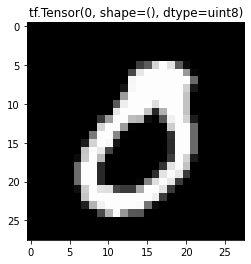

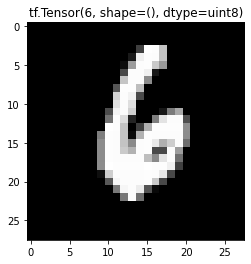

In [9]:
for image, label in train_ds.take(2):
    plt.title(str(label[0]))
    plt.imshow(image[0, :, :,0], 'gray')
    plt.show()

## **Training (Keras)**
keras로 학습 할 때는 기존과 같지만, train_ds는 generator라서 그대로 넣을 수 있음

In [10]:
#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
#model.fit(train_ds, epochs=1000)

## **Optimization**

- Loss Function
- Optimizer

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

- Loss Function를 담을 곳
- Metrics

In [12]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

## **Training**

@tf.function - 기존 session 열었던 것처럼 바로 작동 안 하고, 그래프만 만들고 학습이 시작되면 돌아가도록 함

In [13]:
@tf.function
def train_step(image, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [14]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [16]:
for epoch in range(2):
    for images, labels in train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {}:, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1, train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(), 
                          test_accuracy.result() * 100))

Epoch 1:, Loss: 2.301602602005005, Accuracy: 11.193333625793457, Test Loss: 2.3012306690216064, Test Accuracy: 11.350000381469727
Epoch 2:, Loss: 2.3015377521514893, Accuracy: 11.207777976989746, Test Loss: 2.301211357116699, Test Accuracy: 11.350000381469727
